In [1]:
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



In [2]:
rgb_shades_df = pd.read_csv('/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/colours_rgb_shades_clean.csv')

In [3]:
transform = transforms.Compose([
    transforms.Resize((60, 80)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.labels_df[1] = self.label_encoder.fit_transform(self.labels_df[1])

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = torch.tensor(self.labels_df.iloc[idx, 1], dtype=torch.long)  # Convert label to tensor

        if self.transform:
            image = self.transform(image)

        return image, label

# Create custom dataset
dataset = CustomDataset(csv_file='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/labels.txt', root_dir='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/images', transform=transform)

# Load the trained model for prediction
model = torchvision.models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_encoder.classes_))
model.load_state_dict(torch.load( '/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/models/torch.pth'))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def extract_colors(image_path, num_colors=5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize GrabCut parameters
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, image.shape[1]-10, image.shape[0]-10)  # Rectangle for GrabCut (change if needed)

    # Apply GrabCut algorithm
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    # Use mask to separate foreground
    image_fg = image * mask2[:, :, np.newaxis]

    # Apply K-means clustering to find dominant colors in the foreground
    pixels = image_fg[mask2 == 1]  # Get non-zero pixels for color analysis
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_

    # Get the labels assigned to each pixel
    labels = kmeans.labels_

    # Count the occurrences of each label
    counts = np.bincount(labels)

    return colors.astype(int), image_fg, counts



#COVERT RGB TO HEX
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])


def display_colors_sorted(colors, counts):
    # Sort colors and counts based on counts
    sorted_indices = np.argsort(counts)[::-1]
    sorted_colors = [colors[i] for i in sorted_indices]
    sorted_counts = [counts[i] for i in sorted_indices]
    
    # Create a square image with the sorted colors
    color_img = np.zeros((100, len(sorted_colors)*100, 3), dtype=np.uint8)
    for i, color in enumerate(sorted_colors):
        color_img[:, i*100:(i+1)*100] = color
        hex_color = rgb_to_hex(color)
        print(f"Color {i+1}: {hex_color} (Count: {sorted_counts[i]})")
    
    plt.imshow(color_img)
    plt.axis('off')
    plt.show()
    
    return sorted_colors  # Return the sorted colors for further use
    print("\n")

In [5]:
def find_closest_hex_color(sorted_colors, color_df):
    closest_colors = []
    for color in sorted_colors:
        # Convert RGB to HEX
        hex_color = rgb_to_hex(color)
        hex_color = hex_color.lstrip('#')

        # Calculate the distance to each color in the dataframe
        distances = color_df['RGB Hex'].apply(
            lambda x: sum((int(x[i:i+2], 16) - int(hex_color[i:i+2], 16)) ** 2 for i in (0, 2, 4))
            if len(x) == 6 else float('inf')
        )

        # Get the index of the closest color
        closest_index = distances.idxmin()
        closest_color = color_df.iloc[closest_index]
        closest_colors.append((closest_color['Color Name'], closest_color['RGB Hex']))

    return closest_colors

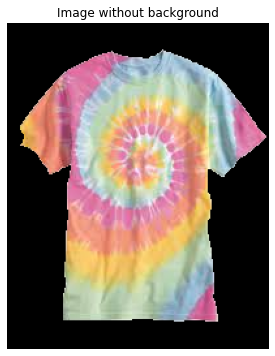



Color 1: #eab575 (Count: 7389)
Color 2: #c7d4c5 (Count: 7294)
Color 3: #dd86a6 (Count: 4671)
Color 4: #98b1ae (Count: 4212)
Color 5: #ca7074 (Count: 2519)


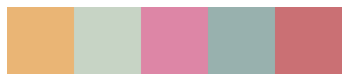



Closest color names and HEX values:
burlywood: #DEB887
honeydew3: #C1CDC1
pink3: #CD919E
grey66: #A8A8A8
PaleVioletRed3: #CD6889


In [7]:
# Example usage
query_image_path = "/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/multi.jpeg"  # Full path to the image file
colors, masked_image, counts = extract_colors(query_image_path)

# Display the image without background
plt.figure(figsize=(6, 6))
plt.imshow(masked_image)
plt.title("Image without background")
plt.axis('off')
plt.show()

print("\n")

sorted_colors = display_colors_sorted(colors, counts)

closest_colors_info = find_closest_hex_color(sorted_colors, rgb_shades_df)

print("\n")

print("Closest color names and HEX values:")
for color_name, hex_color in closest_colors_info:
    print(f"{color_name}: #{hex_color}")